<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Face_Mar2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0
Invalid model-index. Not loading eval results into CardData.


Choose an option:
1: Upload and process your own images
2: Process sample images


Invalid model-index. Not loading eval results into CardData.


Enter your choice (1 or 2): 1


Saving MultipleFaces.jpg to MultipleFaces.jpg
Processing MultipleFaces.jpg...
Found 3 faces


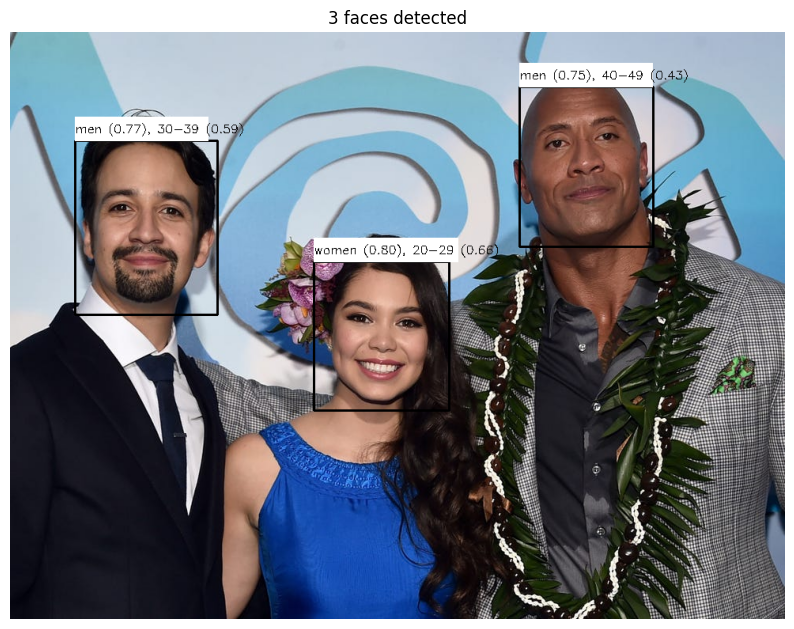

In [3]:
# Face Detection with Age and Gender Prediction
# Install required packages
!pip install inference-sdk transformers

# Import necessary libraries
from inference_sdk import InferenceHTTPClient
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline, AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import io
import requests
from google.colab import files
import os

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Initialize face detection client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="2IGtFaicFMGaMwb2mX8A"
)

# Load age classification model
age_pipe = pipeline("image-classification", model="nateraw/vit-age-classifier")
age_processor = AutoImageProcessor.from_pretrained("nateraw/vit-age-classifier")
age_model = AutoModelForImageClassification.from_pretrained("nateraw/vit-age-classifier")

# Load gender classification model
gender_pipe = pipeline("image-classification", model="Leilab/gender_class")
gender_processor = AutoImageProcessor.from_pretrained("Leilab/gender_class")
gender_model = AutoModelForImageClassification.from_pretrained("Leilab/gender_class")

def detect_faces(image_path):
    """Detect faces using Roboflow API and return their bounding boxes"""
    # Run face detection
    result = CLIENT.infer(image_path, model_id="face-detection-mik1i/21")

    faces_data = []
    if "predictions" in result:
        for face in result["predictions"]:
            confidence = face.get("confidence", 0)

            # Extract bounding box coordinates
            x = face.get("x", face.get("x_center", None))
            y = face.get("y", face.get("y_center", None))
            w = face.get("width", face.get("w", None))
            h = face.get("height", face.get("h", None))

            # If coordinates are in standard format
            if all([x is not None, y is not None, w is not None, h is not None]):
                # Convert to top-left and bottom-right coordinates
                x1 = int(x - w/2)
                y1 = int(y - h/2)
                x2 = int(x + w/2)
                y2 = int(y + h/2)

                faces_data.append({
                    "confidence": confidence,
                    "bbox": (x1, y1, x2, y2)
                })
            else:
                # Check alternative format
                bbox = face.get("bbox", {})
                if bbox:
                    x = bbox.get("x")
                    y = bbox.get("y")
                    w = bbox.get("width")
                    h = bbox.get("height")

                    if all([x is not None, y is not None, w is not None, h is not None]):
                        x1 = int(x - w/2)
                        y1 = int(y - h/2)
                        x2 = int(x + w/2)
                        y2 = int(y + h/2)

                        faces_data.append({
                            "confidence": confidence,
                            "bbox": (x1, y1, x2, y2)
                        })

    return faces_data

def crop_face(image, bbox, padding=0.2):
    """Crop face from image with optional padding"""
    x1, y1, x2, y2 = bbox
    h, w = image.shape[:2]

    # Add padding
    width = x2 - x1
    height = y2 - y1
    pad_w = int(width * padding)
    pad_h = int(height * padding)

    # Ensure boundaries are within image
    x1_padded = max(0, x1 - pad_w)
    y1_padded = max(0, y1 - pad_h)
    x2_padded = min(w, x2 + pad_w)
    y2_padded = min(h, y2 + pad_h)

    # Crop face
    face_crop = image[y1_padded:y2_padded, x1_padded:x2_padded]
    return face_crop, (x1_padded, y1_padded, x2_padded, y2_padded)

def predict_age_gender(face_image):
    """Predict age and gender for a face image"""
    # Convert to PIL Image for transformers
    face_pil = Image.fromarray(face_image)

    # Predict age
    age_result = age_pipe(face_pil)
    age_prediction = age_result[0]["label"]
    age_confidence = age_result[0]["score"]

    # Predict gender
    gender_result = gender_pipe(face_pil)
    gender_prediction = gender_result[0]["label"]
    gender_confidence = gender_result[0]["score"]

    return {
        "age": age_prediction,
        "age_confidence": age_confidence,
        "gender": gender_prediction,
        "gender_confidence": gender_confidence
    }

def process_image(image_path, output_path=None):
    """Process image for face detection, age and gender prediction"""
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Get face bounding boxes
    faces_data = detect_faces(image_path)
    print(f"Found {len(faces_data)} faces")

    # Process each face
    for i, face_data in enumerate(faces_data):
        bbox = face_data["bbox"]
        confidence = face_data["confidence"]

        # Crop face with padding for better prediction
        face_crop, padded_bbox = crop_face(image, bbox)

        # Get age and gender predictions
        predictions = predict_age_gender(face_crop)

        # Draw rectangle around face
        x1, y1, x2, y2 = bbox
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 0), 2)

        # Add text with predictions
        label = f"{predictions['gender']} ({predictions['gender_confidence']:.2f})"
        label += f", {predictions['age']} ({predictions['age_confidence']:.2f})"
        cv2.rectangle(image, (x1, y1-30), (x1 + len(label)*7, y1), (255, 255, 255), -1)
        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Save processed image if output path is provided
    if output_path:
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.title(f"{len(faces_data)} faces detected")
        plt.axis('off')
        plt.savefig(output_path)
        plt.close()

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"{len(faces_data)} faces detected")
    plt.axis('off')
    plt.show()

    return image, faces_data

def upload_and_process():
    """Upload images and process them"""
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        output_path = f"output/processed_{filename}"
        process_image(filename, output_path)

def process_sample_images():
    """Process sample images from URLs"""
    # Sample image URLs - replace with your own
    sample_urls = [
        "https://images.unsplash.com/photo-1573496359142-b8d87734a5a2?q=80&w=1000&auto=format&fit=crop",
        "https://images.unsplash.com/photo-1522529599102-193c0d76b5b6?q=80&w=1000&auto=format&fit=crop",
        "https://images.unsplash.com/photo-1472099645785-5658abf4ff4e?q=80&w=1000&auto=format&fit=crop"
    ]

    for i, url in enumerate(sample_urls):
        # Download image
        response = requests.get(url)
        img_name = f"sample_image_{i+1}.jpg"

        with open(img_name, 'wb') as f:
            f.write(response.content)

        # Process image
        output_path = f"output/processed_{img_name}"
        process_image(img_name, output_path)

# Main execution
print("Choose an option:")
print("1: Upload and process your own images")
print("2: Process sample images")

option = input("Enter your choice (1 or 2): ")

if option == "1":
    upload_and_process()
elif option == "2":
    process_sample_images()
else:
    print("Invalid option. Please run the cell again and enter 1 or 2.")